In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
import datetime

import re

In [2]:
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
spark = SparkSession.builder \
    .appName("Sparkify") \
.getOrCreate()

In [4]:
spark

In [5]:
path = 'data/mini_sparkify_event_data.json'
##path='data/sparkify_log_small.json'
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [6]:
# path = 'medium-sparkify-event-data.json'
# df = spark.read.json(path)
# df.persist()

# Load and clean data

In [7]:
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630807|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [8]:
df.groupby('userid').count().sort(desc('userid')).show()

+------+-----+
|userid|count|
+------+-----+
|    99|  614|
|    98| 2891|
|    97| 2404|
|    96| 2176|
|    95| 2091|
|    94|  187|
|    93|  815|
|    92| 7230|
|    91| 3014|
|    90|   45|
|     9| 3191|
|    89|  801|
|    88| 2465|
|    87| 1003|
|    86|  818|
|    85| 4370|
|    84|   97|
|    83| 1496|
|    82| 2049|
|    81| 2335|
+------+-----+
only showing top 20 rows



In [9]:
df.count()

286500

In [10]:
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"]) 

In [11]:
df_valid.count()

286500

In [12]:
df_valid.filter(df_valid["sessionId"] != "").count()

0

In [13]:
df_valid.filter(df_valid["userId"] != "").count()

278154

In [14]:
df = df_valid.filter(df_valid["userId"] != "")

# Exploratory data analysis
When you work with full datasets, exploratory data analysis is done by loading small datasets and doing basic operations in Spark. In this Workspace, we've provided you with a small dataset that you can explore.

### Defining Customer Churn

After you've done your initial analysis, create a column of `Churn` as labels for the model. I recommend that you define customer churn using the `Cancellation Confirmation` event, which occurs on both paid and free customers. As a bonus quest, you can also dig into the `Downgrade` event.

### Explore data
Once you've defined churn, you can perform some exploratory data analysis to observe the behavior of retained and churn users. You can start by aggregating data from these two types of users to see how many times a particular action occurs or how much music is played over a fixed period of time.

In [15]:
df.groupby('page').count().sort('count').show()

+--------------------+------+
|                page| count|
+--------------------+------+
|Cancellation Conf...|    52|
|              Cancel|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|                Home| 10082|
|           Thumbs Up| 12551|
|            NextSong|228108|
+--------------------+------+



In [16]:
df.groupby('page').count().sort('count').toPandas()

,page,count
0,Cancel,52
1,Cancellation Confirmation,52
2,Submit Downgrade,63
3,Submit Upgrade,159
4,Error,252
5,Save Settings,310
6,About,495
7,Upgrade,499
8,Help,1454
9,Settings,1514


### *Add Churn*

In [25]:
churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list).cast('int'))

array([[<AxesSubplot:title={'center':'itemInSession'}>,
        <AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'registration'}>],
       [<AxesSubplot:title={'center':'sessionId'}>,
        <AxesSubplot:title={'center':'status'}>,
        <AxesSubplot:title={'center':'ts'}>],
       [<AxesSubplot:title={'center':'churn'}>,
        <AxesSubplot:title={'center':'day_time'}>,
        <AxesSubplot:title={'center':'gender_num'}>],
       [<AxesSubplot:title={'center':'level_num'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

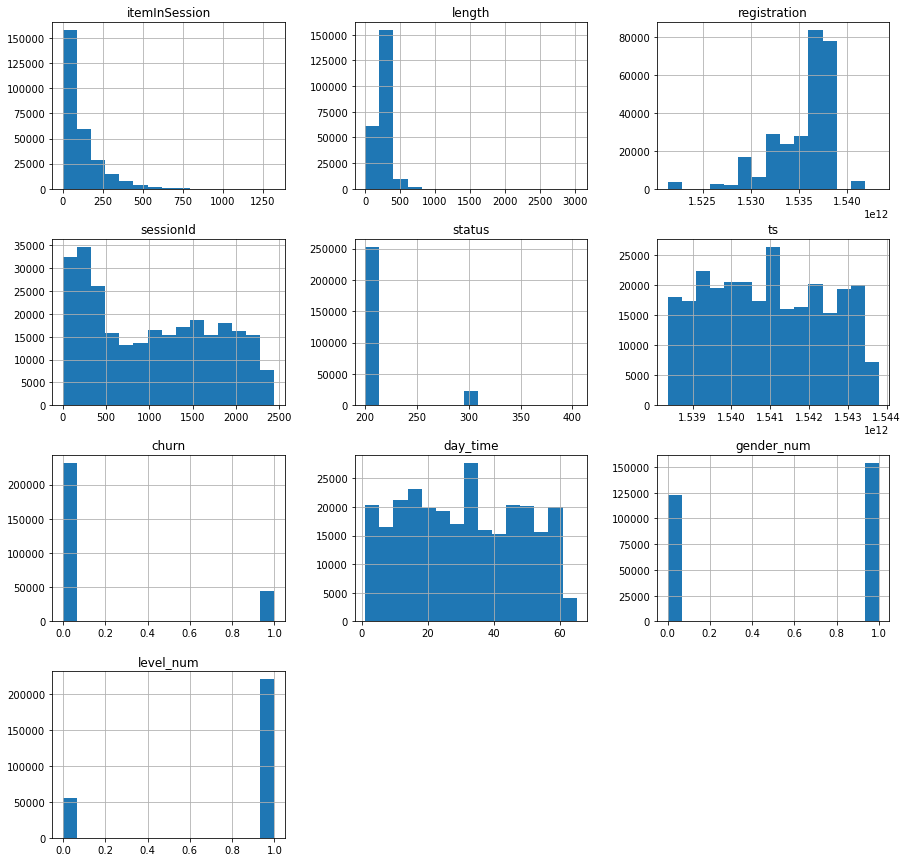

In [74]:
df_withchurn.toPandas().hist(figsize=(15,15), bins=15)

### *1.Expore Gender*

In [26]:
df_churn = df_withchurn.dropDuplicates(["userId"]).groupby(["churn"]).count().withColumnRenamed("count", "churncount")
get_Freq = udf(lambda x,y : (x/y)*100)

In [27]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|     M|   89|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [28]:
df_g = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().withColumnRenamed("count", "genderccount")

In [29]:
df_g.show()

+-----+------+------------+
|churn|gender|genderccount|
+-----+------+------------+
|    1|     F|          20|
|    0|     M|          89|
|    1|     M|          32|
|    0|     F|          84|
+-----+------+------------+



In [30]:
df_gendercount = df_g.join(df_churn, 'churn')
df_gendercount.withColumn("gender_Freq", get_Freq(df_gendercount.genderccount, df_gendercount.churncount).cast('float')).sort("churn").show()

+-----+------+------------+----------+-----------+
|churn|gender|genderccount|churncount|gender_Freq|
+-----+------+------------+----------+-----------+
|    0|     F|          84|       173|  48.554913|
|    0|     M|          89|       173|  51.445087|
|    1|     M|          32|        52|   61.53846|
|    1|     F|          20|        52|   38.46154|
+-----+------+------------+----------+-----------+



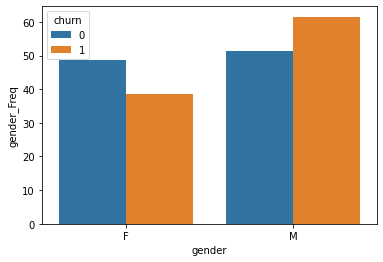

In [31]:
pd_gender = df_gendercount.withColumn("gender_Freq", get_Freq(df_gendercount.genderccount, df_gendercount.churncount).cast('float')).toPandas()
sns.barplot(data=pd_gender, x='gender', y='gender_Freq', hue='churn');

**Exploration conclusion**: Male customer churn rate is slightly higher than female customer

### *2. Expore artist*

In [32]:
df_withchurn.groupby(["churn"]).count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [33]:
df_withchurn.dropDuplicates(["churn", "artist"]).groupby(["churn"]).count().withColumnRenamed("count", "artistcount").sort("churn").show()

+-----+-----------+
|churn|artistcount|
+-----+-----------+
|    0|      16653|
|    1|       8403|
+-----+-----------+



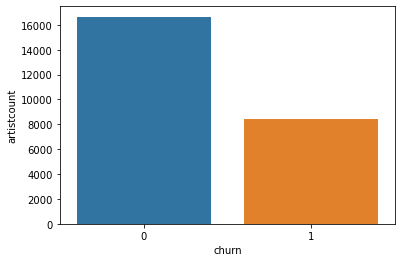

In [34]:
df_artist = df_withchurn.dropDuplicates(["churn", "artist"]).groupby(["churn"]).count().withColumnRenamed("count", "artistcount").sort("churn").toPandas()
sns.barplot(x="churn", y="artistcount", data=df_artist);

**Exploration conclusion**: The number of singers followed by lost users is significantly less than the number of singers followed by active accounts

### *3.Expore Level*

In [35]:
df_withchurn.createOrReplaceTempView("dftable")
df_level = spark.sql('''
select
userId, level,churn
from(SELECT userId, level,churn, row_number() over(partition by userId order by ts desc) rank FROM dftable)
where rank = 1
order by userId
'''
)

In [36]:
df_level.groupby(["level","churn"]).count().show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|    0|  114|
| free|    0|   59|
| paid|    1|   31|
| free|    1|   21|
+-----+-----+-----+



In [37]:
df_l = df_level.groupby(["level","churn"]).count().withColumnRenamed("count", "levelccount")

In [38]:
df_levelcount = df_l.join(df_churn, 'churn')
df_levelcount.withColumn("level_Freq", get_Freq(df_levelcount.levelccount, df_levelcount.churncount).cast('float')).sort("churn").show()

+-----+-----+-----------+----------+----------+
|churn|level|levelccount|churncount|level_Freq|
+-----+-----+-----------+----------+----------+
|    0| paid|        114|       173|  65.89595|
|    0| free|         59|       173| 34.104046|
|    1| free|         21|        52| 40.384617|
|    1| paid|         31|        52| 59.615383|
+-----+-----+-----------+----------+----------+



In [39]:
pd_level = df_levelcount.withColumn("level_Freq", get_Freq(df_levelcount.levelccount, df_levelcount.churncount).cast('float')).toPandas()

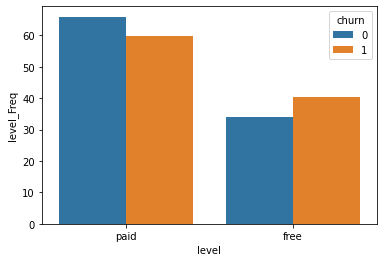

In [40]:
sns.barplot(data=pd_level, x='level', y='level_Freq', hue='churn');

**Exploration conclusion**: The customer churn is more in the paid state, and the customer churn in the paid state is less, so it can be used as a feature column

### *4.Expore Page*

In [41]:
df_page = spark.sql('''
select 
t1.page, 
t1.churn,
t1.pc_count/(t2.p_count*t3.c_count) Freq
from (SELECT 
          page, churn,
          count(page) pc_count      
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by page, churn) t1
left join (SELECT 
          page,
          count(page) p_count      
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by page) t2 on t1.page = t2.page
left join (SELECT churn,
          count(page) c_count      
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by churn) t3 on t1.churn = t3.churn
'''
)

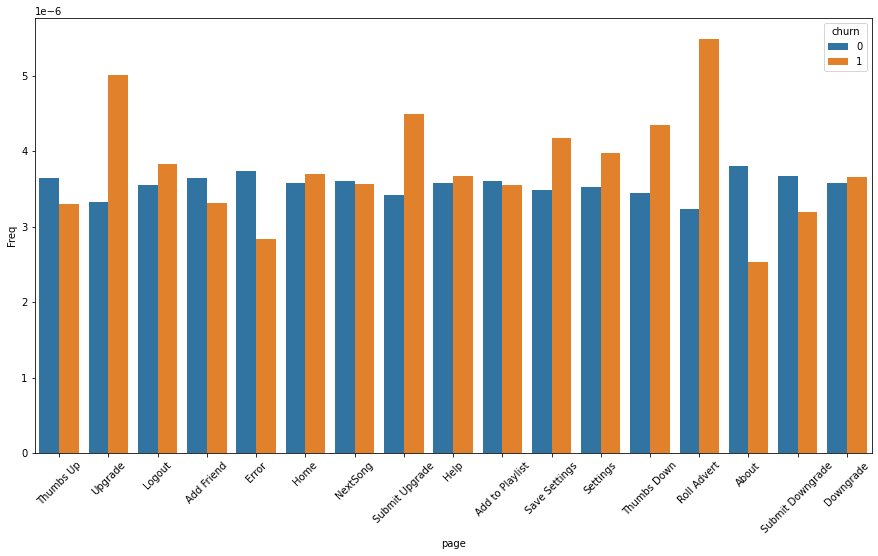

In [42]:
pd_page=df_page.toPandas()
plt.figure(figsize=[15,8])
sns.barplot(data=pd_page, x='page', y='Freq', hue='churn');
plt.xticks(rotation=45);

As shown in the figure above, the ratio of lost customers and active customers on the Submit Downgrade, Thumbs Down, Downgrade, Roll Advert, Upgrade, and Submit Downgrade pages is quite different

### *5.Expore SessionId*

In [43]:
df_withchurn.select(["churn", "sessionId"]).groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [44]:
df_withchurn.select(["churn", "sessionId"]).groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [45]:
df_withchurn.select(["churn", "sessionId"]).groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



**Exploration conclusion**: The average number of sessions for the sessionId of lost customers and active customers is quite different

### *6.Expore songs*

I hope to observe the trend of the number of lost users and active users listening to songs per day in the two months of October and November, and then analyze whether the characteristics of the number of songs listened to each day are very different between lost users and active users. When converting the 'ts' column into a time in days, I hope to count the songs that users listen to every day in groups of days, but when converting the time, only the day is taken alone, and the month is ignored. At that time, I wanted to use interception The function to the month, but the feature "time" that comes out does not meet the needs of visualization, so the month and day are intercepted and added up.

In [46]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day, IntegerType())
df_withchurn = df_withchurn.withColumn("time", get_time(df_withchurn.ts))                                                                              
df_withchurn = df_withchurn.withColumn("day_time", get_month(df_withchurn.ts)*31+get_day(df_withchurn.ts)-310)

In [47]:
df_d = df_withchurn.filter(df_withchurn.page=="NextSong").groupby(["churn", "day_time"]).count().sort('day_time','churn').withColumnRenamed("count", "songccount")

In [48]:
df_churn.show()

+-----+----------+
|churn|churncount|
+-----+----------+
|    1|        52|
|    0|       173|
+-----+----------+



In [58]:
get_song = udf(lambda x,y : (x/y))
df_song = df_d.join(df_churn, 'churn')

In [59]:
df_song.withColumn("song_Freq", get_Freq(df_song.songccount, df_song.churncount).cast('float')).show()

+-----+--------+----------+----------+---------+
|churn|day_time|songccount|churncount|song_Freq|
+-----+--------+----------+----------+---------+
|    1|      60|       163|        52|313.46155|
|    1|      56|       135|        52| 259.6154|
|    1|      55|       199|        52|382.69232|
|    1|      54|       153|        52|294.23077|
|    1|      52|        45|        52| 86.53846|
|    1|      51|        15|        52|28.846153|
|    1|      50|        86|        52|165.38461|
|    1|      49|         9|        52|17.307692|
|    1|      48|        44|        52| 84.61539|
|    1|      47|       436|        52|838.46155|
|    1|      46|       251|        52|482.69232|
|    1|      45|       374|        52| 719.2308|
|    1|      44|       244|        52|469.23077|
|    1|      43|        84|        52|161.53847|
|    1|      42|       479|        52| 921.1539|
|    1|      41|       636|        52|1223.0769|
|    1|      40|       115|        52|221.15384|
|    1|      39|    

In [60]:
song_pd = df_song.withColumn("song_Freq", get_Freq(df_song.songccount, df_song.churncount).cast('float')).sort('day_time').toPandas()

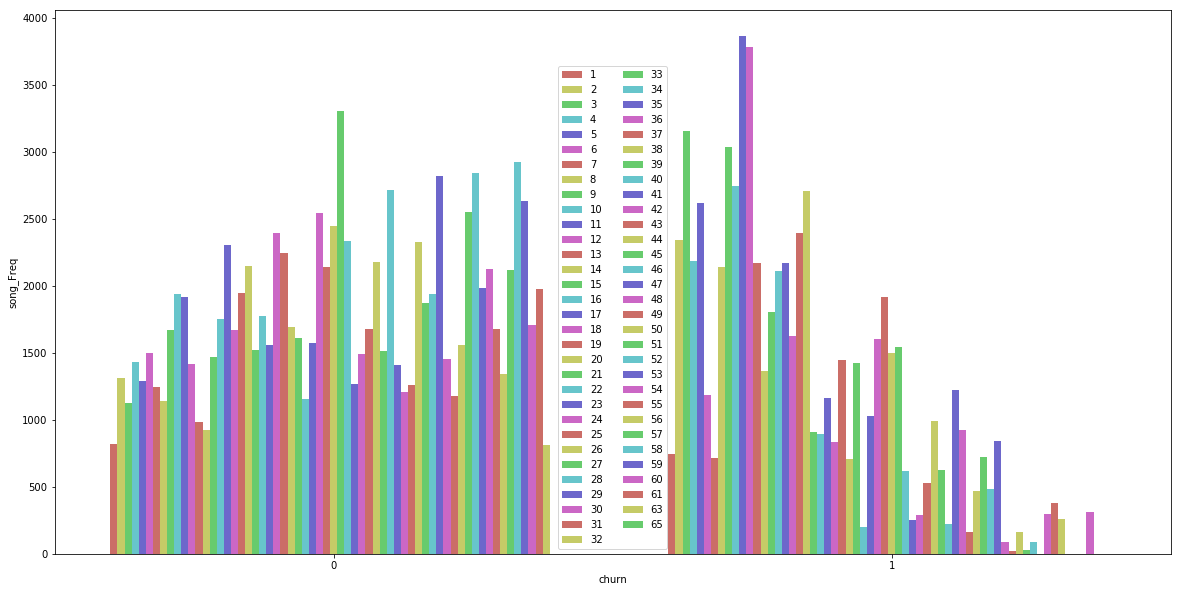

In [61]:
plt.figure(figsize=[20,10])
sns.barplot(data=song_pd , x='churn', y='song_Freq', hue='day_time',palette=sns.color_palette("hls"));
plt.legend(ncol=2);

In [77]:
song_pd.groupby('churn')['songccount'].mean()

churn
0    3043.079365
1     649.892857
Name: songccount, dtype: float64

**Exploration conclusion**: The difference in the number of active users and lost users listening to songs per day is obvious, which can be used as a feature column

# Feature Engineering

In [49]:
df_withchurn = df_withchurn.replace(["M", "F"],["0", "1"], "gender")
df_withchurn = df_withchurn.replace(["free", "paid"], ["0", "1"], "level")

In [50]:
df_withchurn = df_withchurn.withColumn("gender_num", df_withchurn.gender.cast('int'))
df_withchurn = df_withchurn.withColumn("level_num", df_withchurn.level.cast('int'))

In [51]:
df_withchurn.count()

278154

In [52]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day, IntegerType())
df_withchurn = df_withchurn.withColumn("time", get_time(df_withchurn.ts))                                                                              
df_withchurn = df_withchurn.withColumn("day_time", get_month(df_withchurn.ts)*31+get_day(df_withchurn.ts)-310)

In [82]:
df_withchurn.groupby('time','day_time').count().sort('time').show(100)

+----------+--------+-----+
|      time|day_time|count|
+----------+--------+-----+
|2018-10-01|       1| 2337|
|2018-10-02|       2| 4402|
|2018-10-03|       3| 4503|
|2018-10-04|       4| 4530|
|2018-10-05|       5| 4521|
|2018-10-06|       6| 3964|
|2018-10-07|       7| 3133|
|2018-10-08|       8| 3820|
|2018-10-09|       9| 5493|
|2018-10-10|      10| 5818|
|2018-10-11|      11| 6500|
|2018-10-12|      12| 5459|
|2018-10-13|      13| 3464|
|2018-10-14|      14| 2867|
|2018-10-15|      15| 4259|
|2018-10-16|      16| 5077|
|2018-10-17|      17| 6275|
|2018-10-18|      18| 4618|
|2018-10-19|      19| 5626|
|2018-10-20|      20| 6188|
|2018-10-21|      21| 3722|
|2018-10-22|      22| 4271|
|2018-10-23|      23| 4075|
|2018-10-24|      24| 5550|
|2018-10-25|      25| 5642|
|2018-10-26|      26| 4078|
|2018-10-27|      27| 4271|
|2018-10-28|      28| 2535|
|2018-10-29|      29| 3929|
|2018-10-30|      30| 6324|
|2018-10-31|      31| 5693|
|2018-11-01|      32| 6028|
|2018-11-02|      33

In [53]:
df_withchurn =  df_withchurn.filter((df_withchurn.time!='2018-12-01'))

In [54]:
df_withchurn

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: int, time: string, day_time: int, gender_num: int, level_num: int]

In [55]:
df_withchurn.createOrReplaceTempView("dftable")

Feature 1:**gender**--user gender

Feature 2: **artistcount**--the number of singers the user follows

Feature 3: **leve**l--whether the user pays for the last state

Feature 4: **regtime** -- the number of days since the user registered

Feature 5: **se_avg** - user sessionId average number of meetings

Feature 6: **freq_Roll_Advert**--- How often users use the Roll_Adver page

Feature 7: **freq_Submit_Upgrade**-- how often users use the Submit_Upgrade page

Feature 8: **freq_Upgrade**-- how often users use the Submit Downgrade page

Feature 9: **freq_Submit Downgrade**-- how often users use the Upgrade page

Feature 10: **freq_Thumbs Down**-- how often users use the Thumbs Down page

Feature 11: **freq_Downgrade**-- how often users use the Downgrade page

Feature 12: **songs_per_count**--the average number of songs the user listens to per day

Feature 13: **time_per_day**--the average daily active time of users

In [56]:
df_feature1 = spark.sql('''
select 
t1.userId,
t1.gender, 
t1.artistcount,
t2.level,
t1.regtime,
t3.se_avg,
t4.Roll_Advert_count/t4.page_count freq_Roll_Advert,
t4.Submit_Upgrade_count/t4.page_count freq_Submit_Upgrade,
t4.Upgrade_count/t4.page_count freq_Upgrade,
t4.Submit_Downgrade_count/t4.page_count freq_Submit_Downgrade,
t4.Thumbs_Down_count/t4.page_count freq_Thumbs_Down, 
t4.Downgrade_count/t4.page_count freq_Downgrade,
t5.songs_per_count, 
t5.time_per_day,
t1.churn

from  (SELECT 
          userId,
          max(distinct gender_num) gender,
          count(distinct artist) artistcount,
          max(ts)-max(registration) regtime,
          max(distinct churn) churn
          
          FROM dftable 
          group by userId) t1
          
left join(select userId, level_num level
                      from(SELECT userId, level_num,
                      row_number() over(partition by userId order by time desc) rank
                      FROM dftable)
                      where rank = 1
          order by userId) t2 on t1.userId = t2.userId
          
left join(select userId, mean(se_num)  se_avg
          from(SELECT userId, sessionId, count(sessionId) se_num
                  FROM dftable
                  group by userId, sessionId)
          group by userId) t3 on t1.userId = t3.userId

left join(SELECT 
          userId,
          count(case when 
                page = "Roll Advert" 
                then page
                end) Roll_Advert_count,  
          count(case when 
                page = "Submit Upgrade"   
                then page
                end) Submit_Upgrade_count,
          count(case when 
                page = "Upgrade"   
                then page
                end) Upgrade_count,
          count(case when 
                page = "Submit Downgrade" 
                then page
                end) Submit_Downgrade_count, 
          count(case when 
                page = "Thumbs Down"   
                then page
                end) Thumbs_Down_count, 
          count(case when 
                page = "Downgrade"   
                then page
                end) Downgrade_count,
          count(page) page_count
                
          FROM dftable 
          where page not in ("Cancel","Cancellation Confirmation")
          group by userId) t4 on t1.userId = t4.userId

left join(select 
           userId,
          avg(songs_count) songs_per_count, 
          avg(time_day) time_per_day

          from  (SELECT 
                    userId,
                    day_time,
                    count(song) songs_count,
                    max(ts) -min(ts) time_day
          
                    FROM dftable 
                    where page ="NextSong"
                    group by userId, day_time)
          group by userId) t5 on t1.userId = t5.userId
          '''
          )

In [57]:
feature1_pd = df_feature1.toPandas()

In [88]:
feature1_pd.head(10)

,userId,gender,artistcount,level,regtime,se_avg,freq_Roll_Advert,freq_Submit_Upgrade,freq_Upgrade,freq_Submit_Downgrade,freq_Thumbs_Down,freq_Downgrade,songs_per_count,time_per_day,churn
0,100010,1,252,0,4807612000,54.428571,0.136483,0.000000,0.005249,0.000000,0.013123,0.000000,30.555556,7.136889e+06,0
1,200002,0,339,1,6054448000,79.000000,0.014768,0.002110,0.004219,0.000000,0.012658,0.010549,55.285714,1.357714e+07,0
2,125,0,8,0,6161779000,11.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.762000e+06,1
3,124,1,2232,1,11366431000,166.379310,0.000829,0.000000,0.000000,0.000000,0.008497,0.008497,113.305556,3.008839e+07,0
4,51,0,1385,1,1680985000,246.400000,0.000000,0.000000,0.000000,0.000000,0.008530,0.009342,175.916667,5.267108e+07,1
5,7,0,142,0,6288035000,28.714286,0.079602,0.000000,0.009950,0.000000,0.004975,0.000000,18.750000,4.546250e+06,0
6,15,0,1302,1,4882773000,151.866667,0.000439,0.000000,0.000000,0.000000,0.006146,0.012291,95.700000,3.300535e+07,0
7,54,1,1744,1,9568946000,92.891892,0.013683,0.000291,0.000291,0.000291,0.008443,0.011354,91.645161,3.602013e+07,1
8,155,1,643,1,2035240000,167.000000,0.007984,0.000998,0.001996,0.000000,0.002994,0.011976,117.142857,2.812043e+07,0
9,100014,0,233,1,7351206000,51.666667,0.006494,0.000000,0.000000,0.000000,0.009740,0.009740,28.555556,7.014333e+06,1


In [89]:
df_withchurn.groupby('time','day_time').count().sort('time').show(300)

+----------+--------+-----+
|      time|day_time|count|
+----------+--------+-----+
|2018-10-01|       1| 2337|
|2018-10-02|       2| 4402|
|2018-10-03|       3| 4503|
|2018-10-04|       4| 4530|
|2018-10-05|       5| 4521|
|2018-10-06|       6| 3964|
|2018-10-07|       7| 3133|
|2018-10-08|       8| 3820|
|2018-10-09|       9| 5493|
|2018-10-10|      10| 5818|
|2018-10-11|      11| 6500|
|2018-10-12|      12| 5459|
|2018-10-13|      13| 3464|
|2018-10-14|      14| 2867|
|2018-10-15|      15| 4259|
|2018-10-16|      16| 5077|
|2018-10-17|      17| 6275|
|2018-10-18|      18| 4618|
|2018-10-19|      19| 5626|
|2018-10-20|      20| 6188|
|2018-10-21|      21| 3722|
|2018-10-22|      22| 4271|
|2018-10-23|      23| 4075|
|2018-10-24|      24| 5550|
|2018-10-25|      25| 5642|
|2018-10-26|      26| 4078|
|2018-10-27|      27| 4271|
|2018-10-28|      28| 2535|
|2018-10-29|      29| 3929|
|2018-10-30|      30| 6324|
|2018-10-31|      31| 5693|
|2018-11-01|      32| 6028|
|2018-11-02|      33

# Modeling
Divide the full dataset into train, test, and validation sets. Test out several machine learning methods you've learned. Evaluate the accuracy of different machine learning methods and adjust parameters according to the situation. You pick the best model based on accuracy and report the results on the training set. Because the data set of lost customers is small, and F1 score is selected as the optimization metric

In [58]:
df_feature1.persist()

DataFrame[userId: string, gender: int, artistcount: bigint, level: int, regtime: bigint, se_avg: double, freq_Roll_Advert: double, freq_Submit_Upgrade: double, freq_Upgrade: double, freq_Submit_Downgrade: double, freq_Thumbs_Down: double, freq_Downgrade: double, songs_per_count: double, time_per_day: double, churn: int]

In [91]:
df_feature1.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [59]:
path1 = "mini_churn_data.csv"

In [60]:
df_feature1.repartition(1).write.save(path1, format="csv", header=True)

In [61]:
df_model = spark.read.csv(path1, header=True)
df_model.persist()

DataFrame[userId: string, gender: string, artistcount: string, level: string, regtime: string, se_avg: string, freq_Roll_Advert: string, freq_Submit_Upgrade: string, freq_Upgrade: string, freq_Submit_Downgrade: string, freq_Thumbs_Down: string, freq_Downgrade: string, songs_per_count: string, time_per_day: string, churn: string]

In [62]:
num_features_list = df_model.columns[1:]
for f in num_features_list:
    f_name = f + "_num"
    df_model = df_model.withColumn(f_name, df_model[f].cast("float"))
    df_model = df_model.drop(f)

In [63]:
df_model.persist()

DataFrame[userId: string, gender_num: float, artistcount_num: float, level_num: float, regtime_num: float, se_avg_num: float, freq_Roll_Advert_num: float, freq_Submit_Upgrade_num: float, freq_Upgrade_num: float, freq_Submit_Downgrade_num: float, freq_Thumbs_Down_num: float, freq_Downgrade_num: float, songs_per_count_num: float, time_per_day_num: float, churn_num: float]

### Create a Vector

In [64]:
assembler = VectorAssembler(inputCols=df_model.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_model)

### Scaling Features

In [65]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [66]:
data.persist()

DataFrame[userId: string, gender_num: float, artistcount_num: float, level_num: float, regtime_num: float, se_avg_num: float, freq_Roll_Advert_num: float, freq_Submit_Upgrade_num: float, freq_Upgrade_num: float, freq_Submit_Downgrade_num: float, freq_Thumbs_Down_num: float, freq_Downgrade_num: float, songs_per_count_num: float, time_per_day_num: float, churn_num: float, NumFeatures: vector, ScaledNumFeatures: vector]

In [67]:
data1 = data.select(col("churn_num").alias("label"), col("ScaledNumFeatures").alias("features"))

In [68]:
#new
data1.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[2.00127105192366...|
|  0.0|[0.0,0.5635679955...|
|  1.0|(13,[1,3,4,5,11,1...|
|  0.0|[2.00127105192366...|
|  1.0|[0.0,2.3024828136...|
|  0.0|[0.0,0.2360668299...|
|  0.0|[0.0,2.1645000890...|
|  1.0|[2.00127105192366...|
|  0.0|[2.00127105192366...|
|  1.0|[0.0,0.3873490942...|
|  0.0|[2.00127105192366...|
|  0.0|(13,[0,1,3,4,5,11...|
|  1.0|[0.0,2.0630910986...|
|  0.0|[2.00127105192366...|
|  0.0|[0.0,2.1246014698...|
|  0.0|[2.00127105192366...|
|  1.0|[0.0,0.3441255901...|
|  1.0|[0.0,2.9990462063...|
|  0.0|[2.00127105192366...|
|  0.0|[0.0,0.3241762806...|
+-----+--------------------+
only showing top 20 rows



### Sub-experimental and test data

In [69]:
train, validation = data1.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [70]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(13,[0,1,2,3,4,11...|
|  0.0|(13,[0,1,2,3,4,11...|
|  0.0|(13,[0,1,3,4,5,11...|
|  0.0|(13,[0,1,3,4,5,11...|
|  0.0|(13,[0,1,3,4,5,11...|
|  0.0|(13,[1,2,3,4,9,11...|
|  0.0|(13,[1,3,4,5,7,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,9,11...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|(13,[1,3,4,5,11,1...|
|  0.0|[0.0,0.0615103711...|
|  0.0|[0.0,0.2360668299...|
|  0.0|[0.0,0.2377292724...|
+-----+--------------------+
only showing top 20 rows



## Model 1 - Logistic Regression

In [36]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.01, 0.1]) \
    .addGrid(lrs.aggregationDepth,[2, 5]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [37]:
#Train the model with the train data  
Model_lrs = crossval_lrs.fit(train)
Model_lrs.avgMetrics  #The accuracy of the model for each parameter combination

[0.7706345938714102,
 0.7706345938714102,
 0.7305668181946918,
 0.7305668181946918,
 0.7756185246112259,
 0.7756185246112259,
 0.6790953215808185,
 0.6790953215808185,
 0.7679284074683725,
 0.7679284074683725,
 0.6790953215808185,
 0.6790953215808185]

## Model 2 - Decision Tree

In [71]:
dts = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dts.impurity,['entropy', 'gini']) \
    .addGrid(dts.maxDepth,[3, 4, 5, 6, 7, 8]) \
    .build()
crossval_dts = CrossValidator(estimator=dts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [72]:
#Train the model with the train data 5
cvModel_dts = crossval_dts.fit(train)
cvModel_dts.avgMetrics #The accuracy of the model for each parameter combination

[0.724504447857406,
 0.7224765428148826,
 0.7250428314592698,
 0.7130109167399149,
 0.7090036873089567,
 0.7127163588182382,
 0.7323962212312691,
 0.7421945593763474,
 0.7089917674739835,
 0.7028656618763465,
 0.6982894879311711,
 0.6982894879311711]

## Model 3 - Gradient Boosted Tree（GBT）

In [38]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[5, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 8]) \
    .addGrid(gbts.maxBins ,[10, 5]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [39]:
#train the model with train data
Model_gbt = crossval_gbts.fit(train)
Model_gbt.avgMetrics

[0.7540425181151524,
 0.7500600692291767,
 0.7454196961592902,
 0.780793382616118,
 0.7128855151605772,
 0.7413916440200884,
 0.7841967933487018,
 0.7831336937583105,
 0.7487596945325394,
 0.7800044680906968,
 0.7071079276716559,
 0.7437983702906121]

## Model 4 - Random Forest

In [41]:
# The Random Forest model
rfc = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(rfc.maxDepth,[5, 10]) \
    .addGrid(rfc.impurity,['entropy', 'gini']) \
    .addGrid(rfc.maxBins ,[10, 5]) \
    .addGrid(rfc.numTrees ,[20, 10]) \
    .addGrid(rfc.featureSubsetStrategy ,['sqrt', 'onethird']) \
    .build()

crossval_rfc = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [42]:
Model_rfc = crossval_rfc.fit(train)
Model_rfc.avgMetrics

[0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008,
 0.7754144722980008]

### Evaluate the best model by F1 score using validation data

Introduction to the principle of F1-score---F1 Score (F1 Score), is an indicator used in statistics to measure the accuracy of a two-class (or multi-task two-class) model. The F1 score can be regarded as a weighted average of model precision and recall. Its maximum value is 1 and the minimum value is 0. The larger the value, the better the model. If there are 100 samples, including 1 positive sample and 99 negative samples, if the prediction of the model only outputs 0, then the correct rate is 99%. At this time, it is obviously wrong to use the correct rate to measure the quality of the model. Both LogisticRegression() and GBTClassifier() belong to classification models, and the F1 score can take into account the accuracy and recall of the classification model at the same time

In [34]:
def get_model_metrics(model,data,):
    metrics = []
    predict = model.transform(data)
    tp = predict.filter("label = 1 and prediction = 1").count()
    fp = predict.filter("label = 0 and prediction = 1").count()
    fn = predict.filter("label = 1 and prediction = 0").count()
    n =  predict.count()
    accuracy = (n -(fp +fn))/n
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    f1 = 2*precision*recall / (precision+recall)
    metrics.append(accuracy)
    metrics.append(precision)
    metrics.append(recall)
    metrics.append(f1)
    metrics_names = ['accuracy', 'precision', 'recall', 'f1score']
    dfmetrics = pd.DataFrame(metrics,index=metrics_names)
    return dfmetrics

In [45]:
lrs_train = get_model_metrics(Model_lrs,train)
lrs_validation = get_model_metrics(Model_lrs,validation)
rfc_train = get_model_metrics(Model_rfc,train)
rfc_validation = get_model_metrics(Model_rfc,validation)
gbt_train = get_model_metrics(Model_gbt,train)
gbt_validation = get_model_metrics(Model_gbt,validation)
dts_train = get_model_metrics(cvModel_dts,train)
dts_validation = get_model_metrics(cvModel_dts,validation)

In [47]:
df_metrics = pd.concat([lrs_train, lrs_validation,rfc_train, rfc_validation,gbt_train, gbt_validation,dts_train, dts_validation], axis=1)
df_metrics.columns = ['Mode_lrs_train', 'Mode_lrs_validation', 'Mode_rfc_train', 'Mode_rfc_validation','Mode_gbt_train', 'Mode_gbt_validation','Mode_dts_train', 'Mode_dts_validation']
df_metrics

,Mode_lrs_train,Mode_lrs_validation,Mode_rfc_train,Mode_rfc_validation,Mode_gbt_train,Mode_gbt_validation,Mode_dts_train,Mode_dts_validation
accuracy,0.835227,0.781250,0.883523,0.802083,0.857955,0.770833,0.877841,0.781250
precision,0.806452,0.571429,1.000000,0.666667,0.935484,0.500000,0.886364,0.533333
recall,0.324675,0.181818,0.467532,0.272727,0.376623,0.318182,0.506494,0.363636
f1score,0.462963,0.275862,0.637168,0.387097,0.537037,0.388889,0.644628,0.432432


Conclusion analysis:

I use f1score and AUC to evaluate the model. Experiments were performed on Logistic Regression, Decision Trees, Gradient Boosting, Random Forest classifiers. Decision tree classifiers perform best and are immune to data imbalance.

**in conclusion**:
The machine learning model successfully predicted the activities that users were most likely to end up with unsubscribing. Although all four models performed well, the decision tree classifier model seemed to be the best. However, other models need to be retuned with different settings to reduce overfitting.
It is important to us to accurately label customers as "churn". Because if we offer a free product, we may incur unnecessary costs, which may confuse users if they don't think about churn, or if we send a message about their reduced activity.

### *How to improve an existing implementation?*
Although the current implementation has achieved good results, it is possible to improve the results by one or more of the following measures:

1. Process more observations by increasing the dataset size

2. Try more parameters of the selected model.

3. Add important feature columns, such as the change in the number of songs a user listens to every day or the change slope of the online time. This may reflect that the activity of some users is gradually decreasing and gradually losing, and the visualization shown above also shows that the number of active users listening to songs increases steadily over time, and there is an upward trend, while the number of lost users listening to songs increases with time. The increase in time decreased significantly.

In [ ]:
spark.stop()